<img align='left' alt='ESO Logo' src='http://archive.eso.org/i/esologo.png'>  

# &nbsp; ESO Science Archive Programmatic: HOWTOs

# HOW TO Obtain and Extract Information Between Large, Linked ESO Catalogues (e.g., VVVX Survey)

The European Southern Observatory (ESO) Archive provides access to a wide range of astronomical data, including reduced or fully calibrated datasets and derived catalogs contributed by ESO program PIs or produced using ESO calibration pipelines. These datasets are integrated into the ESO Science Archive Facility and can be explored through tools like the [ESO Catalogue Facility](https://www.eso.org/qi/) and the [Archive Science Portal](http://archive.eso.org/scienceportal/home).

One powerful way to interact with these datasets programmatically is through the [_programmatic access_](http://archive.eso.org/programmatic/#TAP) services such as `tap_cat` and `tap_obs`. Python wrappers like `archive_catalogues` and `archive_observations`—part of the [ESOAsg package](https://github.com/EmAstro/ESOAsg)—offer an efficient way to integrate these tools into Python workflows, enabling streamlined access and data analysis.

## VVVX and VIRAC2 Data Context

The VVVX survey is an extension of the VISTA Variables in the Via Lactea (VVV) survey, using the VISTA telescope at Cerro Paranal. It covers 1,700 square degrees of the southern Galactic plane and bulge and spans additional epochs (2016–2019) over the original VVV area. The [VIRAC2 catalogue](https://doi.org/10.18727/archive/67) includes precise astrometric and photometric data for over 545 million unique sources in the ZYJHKs bands, leveraging Gaia DR3 for absolute astrometry.

VIRAC2 consists of five primary database tables accessible via the ESO archive:

1. **VVVX_VIRAC_V2_SOURCES**: Aggregate source data (positions, proper motions, mean photometry).
2. **VVVX_VIRAC_V2_REJECTED_SOURCES**: Rejected sources that failed quality control but may contain interesting transient sources.
3. **VVVX_VIRAC_V2_LC**: Time series data (photometric and astrometric light curves).
4. **VVVX_VIRAC_V2_REJECTED_LC**: Rejected time series data.
5. **VVVX_VIRAC_V2_OBS**: Observation metadata (e.g., image filenames, seeing conditions).

These resources support advanced queries, including cross-referencing between tables (e.g., linking light curve data to source positions).

## Usage Example with Python

For an interactive experience, you can use Jupyter Notebooks to execute and modify code dynamically. This approach is particularly helpful for navigating and extracting data from complex catalogs like VIRAC2.

**Usage**: You can access this file as an interactive jupyter notebook, which you can download and run on your machine [(instructions)](https://jupyter.org/install). To interact with the jupyter notebook (if you have download it): move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER; you can also modify the code and execute it at will.

**Version**: Please note that this notebook uses Python version 3.12.7 and Jupyter Notebook version 7.2.2. Compatibility with other versions cannot be guaranteed.

**Authors**: Ashley Thomas Barnes

---
## <a id='imports'>0. Imports - inc. ESOAsg package</a>

In [1]:
from ESOAsg import archive_catalogues # ESO Archive Catalogues

from astropy.coordinates import SkyCoord # Astropy coordinates
from astropy.io import fits # Astropy FITS files
import astropy.constants as const # Astropy constants
import astropy.units as u # Astropy units
import matplotlib.pyplot as plt # Matplotlib
import numpy as np # Numpy
import os # OS
from PyAstronomy import pyasl # PyAstronomy - used for Baricentric correction if not in header

# # Set the default font size and weight for plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True

---
## <a id='check'>1. Get inital info on the VVVX survey catalogues </a>

### <a id='query_all'>1.1  Query all ESO catalogues </a>

To begin, you need to know the name of the table where the information are stored. For this, you can either check the [query interface webpage](https://www.eso.org/qi/) or you can obtain an astropy table of all catalogues (most recent versions only) using:
```python
archive_catalogues.all_catalogues_info(all_versions=False)
```

In [2]:
all_catalogues = archive_catalogues.all_catalogues_info(all_versions=False) # Get all the available catalogues
all_catalogues['collection', 'table_name', 'instrument', 'number_rows', 'number_columns'].show_in_notebook() # Show the available catalogues in a Jupyter notebook

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,collection,table_name,instrument,number_rows,number_columns
0,1101.A-0127,AMUSED_MAIN_SOURCE_CAT_V1,MUSE,2221,312
1,195.B-0283,GNS_catalogue_V1,HAWKI,3277646,27
2,196.D-0214,EREBOS_RV_cat_fits_V1,FORS2,359,6
3,196.D-0214,EREBOS_cat_fits_V1,FORS2,9,6
4,AMBRE,AMBRE_HARPS_V1,HARPS,126688,27
5,AMBRE,AMBRE_UVES_V1,UVES,51897,33
6,AMBRE,AMBRE_V1,FEROS,18618,33
7,ATLASGAL,ATLASGAL_V1,APEXBOL,10861,10
8,FDS,FDS_SourceCatalogue_V1,OMEGACAM,3112605,50
9,GAIAESO,GES_2021_VRAD,MULTI,110762,14


### <a id='query_vvvx1'>1.2  Query the VVVX catalogues </a>

Now that we know we would like the ``VVVX`` collections, we can narrow down our search, and check what columns are in them.

In [3]:
all_catalogues_vvv = all_catalogues[all_catalogues['collection'] == 'VVVX'] # Get all the VVVX catalogues
all_catalogues_vvv['collection', 'table_name', 'title', 'number_rows', 'number_columns', 'version'].show_in_notebook(show_row_index=False, display_length=6)

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


collection,table_name,title,number_rows,number_columns,version
VVVX,VVVX_VIRAC_V2_LC,VIRAC2 time series,95768366366,22,1
VVVX,VVVX_VIRAC_V2_OBS,VIRAC2 observation details,197423,16,1
VVVX,VVVX_VIRAC_V2_REJECTED_LC,VIRAC2 time series - Rejected Sources,27419652812,22,1
VVVX,VVVX_VIRAC_V2_REJECTED_SOURCES,VIRAC2 source catalogue - Rejected Sources,844909545,87,1
VVVX,VVVX_VIRAC_V2_SOURCES,VIRAC2 source catalogue,545346533,87,1


We see that there are 5 VVVX catalogues: 
* ``VVVX_VIRAC_V2_SOURCES`` - Table with the sources
* ``VVVX_VIRAC_V2_REJECTED_SOURCES`` - Table with the rejected sources
* ``VVVX_VIRAC_V2_LC`` -Table with the light curves for the sources 
* ``VVVX_VIRAC_V2_REJECTED_SOURCES_LC`` - Table with the light curves for the rejected sources
* ``VVVX_VIRAC_V2_OBS`` - Table with the observation conditions 

In [4]:
tablename_vvvx_sources =                'VVVX_VIRAC_V2_SOURCES' # Table with the sources
tablename_vvvx_sources_rejected =       'VVVX_VIRAC_V2_REJECTED_SOURCES' # Table with the rejected sources
tablename_vvvx_sources_lc =             'VVVX_VIRAC_V2_LC' # Table with the light curves of the sources
tablename_vvvx_sources_lc_rejected =    'VVVX_VIRAC_V2_REJECTED_SOURCES_LC' # Table with the light curves of the rejected sources
tablename_vvvx_obs =                    'VVVX_VIRAC_V2_OBS' # Table with the observations conditions

In [5]:
columns_dict = {} # Dictionary to store the columns of the tables
for table_name in all_catalogues_vvv['table_name']:
    columns_dict[table_name] = archive_catalogues.columns_info(tables=table_name)

# Show the columns of the VVVX_VIRAC_V2_SOURCES table
columns_dict[tablename_vvvx_sources].show_in_notebook(show_row_index=False, display_length=5) 

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


table_name,column_name,ucd,datatype,description,unit
VVVX_VIRAC_V2_SOURCES,sourceid,meta.id;meta.main,BIGINT,unique source identified,
VVVX_VIRAC_V2_SOURCES,astfit_epochs,meta.number;time.epoch,SMALLINT,number of epochs used for astrometric solution,
VVVX_VIRAC_V2_SOURCES,astfit_params,meta.number,SMALLINT,number of astrometric solution parameters,
VVVX_VIRAC_V2_SOURCES,duplicate,meta.code,SMALLINT,flag indicating a likely duplicate entry,
VVVX_VIRAC_V2_SOURCES,ref_epoch,time.epoch,DOUBLE,astrometric reference epoch,yr
VVVX_VIRAC_V2_SOURCES,ra,pos.eq.ra;meta.main,DOUBLE,right ascension,deg
VVVX_VIRAC_V2_SOURCES,ra_error,stat.error;pos.eq.ra,DOUBLE,uncertainty on right ascension,mas
VVVX_VIRAC_V2_SOURCES,de,pos.eq.dec;meta.main,DOUBLE,declination,deg
VVVX_VIRAC_V2_SOURCES,de_error,stat.error;pos.eq.dec,DOUBLE,uncertainty on declination,mas
VVVX_VIRAC_V2_SOURCES,parallax,pos.parallax.trig,DOUBLE,trigonometric parallax,mas


---
## <a id='query_vvvx2'>2. Query the VVVX survey source catalogue </a>

``VVVX_VIRAC_V2_SOURCES`` is the main ``SOURCE`` table of sources in the survey. 

The total number of rows in the table is 545,346,533 so downloading the whole table can be difficult. 
Here we limit our search to the brightest Ks 10,000,000 sources in the catalouge. 

Be careful uncommenting the following part of the code. 

```python 
table_vvvx_sources.show_in_notebook(show_row_index=False, display_length=5) # Show the columns of the table in a Jupyter notebook
```

As this can make the notebook very large, and cause difficulties in displaying. A possible alternative could be to write the file out and check in another viewer using one of the following. 

```python
table_vvvx_sources.write('VVVX_VIRAC_V2_SOURCES.fits', format='fits', overwrite=True) # Write the table to a FITS file
table_vvvx_sources.write('VVVX_VIRAC_V2_SOURCES.csv', format='ascii.csv', overwrite=True) # Write the table to a CSV file
table_vvvx_sources.write('VVVX_VIRAC_V2_SOURCES.tex', format='ascii.aastex', overwrite=True) # Write the table to a LaTeX file
```

In [6]:
selected_columns = ['sourceid', 'ra', 'de'] # Define the columns to be selected
table_vvvx_sources = archive_catalogues.get_catalogues(tables=tablename_vvvx_sources, columns=selected_columns, maxrec=1e6, order_by='phot_ks_mean_mag') 
# table_vvvx_sources.show_in_notebook(show_row_index=False, display_length=5) # Show the columns of the table in a Jupyter notebook

# table_vvvx_sources.write('VVVX_VIRAC_V2_SOURCES.fits', format='fits', overwrite=True) # Write the table to a FITS file
# table_vvvx_sources.write('VVVX_VIRAC_V2_SOURCES.csv', format='ascii.csv', overwrite=True) # Write the table to a CSV file
# table_vvvx_sources.write('VVVX_VIRAC_V2_SOURCES.tex', format='ascii.aastex', overwrite=True) # Write the table to a LaTeX file

/opt/anaconda3/lib/python3.12/site-packages/pyvo/dal/query.py:339: DALOverflowWarning: Partial result set. Potential causes MAXREC, async storage space, etc.
  warn("Partial result set. Potential causes MAXREC, async storage space, etc.",
[INFO]    :: The query to VVVX_VIRAC_V2_SOURCES returned 1000000 entries (with a limit set to maxrec=1000000.0)


### <a id='query_vvvx21'>2.1  Check distribution of sources on the sky </a>

Here we check the distibution of these bright sources on the sky. 


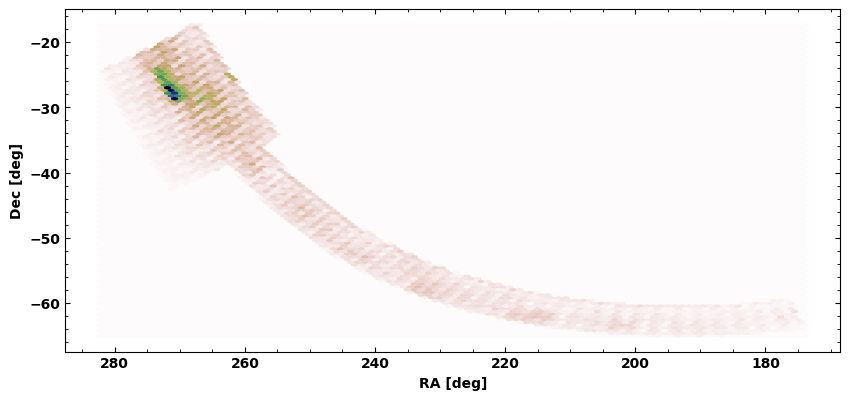

In [7]:
fig = plt.figure(figsize=(10, 10)) # Create a figure

ax = fig.add_subplot(111) # Add a subplot with Mollweide projection
ax.set_aspect('equal') # Set the aspect ratio to be equal

ax.hexbin(table_vvvx_sources['ra'], table_vvvx_sources['de'], cmap='gist_earth_r', linewidths=0.1)

ax.set_xlabel('RA [deg]') # Set the x-axis label
ax.set_ylabel('Dec [deg]') # Set the y-axis label
ax.invert_xaxis() # Flip the x-axis

fig.savefig('./figures/VVVX_sources_sky_distribution.png', dpi=300, bbox_inches='tight') # Save the figure

### <a id='query_vvvx22'>2.2 Complex queries with TAP commands </a>

We can also make more complex filtering of the table using TAP commands such as the following. 

This would select all source table data of high pm star candidates (section 4.1.1 of Smith et al. 2025). 

This should return 21 rows.

In [ ]:
query = '''SELECT *
            FROM VVVX_VIRAC_V2_SOURCES
            WHERE parallax>10
            AND parallax/parallax_error >= 5
            AND ks_n_det > 0.5 * ks_n_obs
            AND sqrt(power(pmra,2)+power(pmde,2)) > 500
            AND ks_n_amb < 0.4 * ks_n_det
            AND ks_last_epoch-ks_first_epoch > 0.5*365.2422
            AND ks_n_det > 20'''

result = archive_catalogues.query_tap(query)
result.show_in_notebook(show_row_index=False, display_length=5)

[INFO]    :: The query returned 21 entries (with a limit set to maxrec=None)
         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


astfit_epochs,astfit_params,chisq,de,de_error,de_parallax_corr,de_pmde_corr,de_pmra_corr,duplicate,h_n_amb,h_n_det,h_n_obs,j_n_amb,j_n_det,j_n_obs,ks_Stetson_I,ks_Stetson_J,ks_Stetson_K,ks_Stetson_group_count,ks_eta,ks_eta_f,ks_first_epoch,ks_last_epoch,ks_mad,ks_med_err,ks_n_amb,ks_n_det,ks_n_obs,ks_p0,ks_p1,ks_p100,ks_p16,ks_p2,ks_p25,ks_p32,ks_p4,ks_p5,ks_p50,ks_p68,ks_p75,ks_p8,ks_p84,ks_p92,ks_p95,ks_p96,ks_p98,ks_p99,ks_skew,parallax,parallax_error,parallax_pmde_corr,parallax_pmra_corr,phot_h_mean_mag,phot_h_n_epochs,phot_h_std_mag,phot_j_mean_mag,phot_j_n_epochs,phot_j_std_mag,phot_ks_mean_mag,phot_ks_n_epochs,phot_ks_std_mag,phot_y_mean_mag,phot_y_n_epochs,phot_y_std_mag,phot_z_mean_mag,phot_z_n_epochs,phot_z_std_mag,pmde,pmde_error,pmra,pmra_error,pmra_pmde_corr,ra,ra_de_corr,ra_error,ra_parallax_corr,ra_pmde_corr,ra_pmra_corr,ref_epoch,sourceid,uwe,y_n_amb,y_n_det,y_n_obs,z_n_amb,z_n_det,z_n_obs
,,,deg,mas,,,,,,,,,,,,,,,,,d,d,mag,mag,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mas / yr,mas / yr,mas / yr,mas / yr,,deg,,mas,,,,yr,,,,,,,,
186,5,306.0574,-34.67343948470384,0.24487962952394715,0.018261325,0.101412594,-0.0074607697,0,8,12,12,9,13,13,0.14303103824678648,0.11827582327951655,0.7642475296627691,86,1.7698554908565982,1216824769.1811159,55444.01943446,58717.134680970004,0.008493423,0.01655115,12,186,188,12.744979,12.752619,12.888269,12.766132,12.756135,12.770881,12.773408,12.75856,12.759347,12.778631,12.785298,12.787492,12.76052,12.790328,12.792994,12.796844,12.798289,12.8012905,12.827868,2.7455304,16.701090631088064,0.7351169408375946,-0.0100412,-0.40855578,13.0613575,4,0.0059218328,13.529919,4,0.009546029,12.779375,174,0.015512448,14.034725,2,0.0008263589,14.548061,2,0.00028562587,-496.61012216757626,0.3062773985291653,125.26121467522779,0.37135424097064046,0.0041023903,257.6270270669558,0.0054955217,0.17353025391522597,0.3009377,-0.003021776,0.33462676,2014.0,14066547002206,0.91320527,2,4,4,2,4,4
162,5,242.18576,-38.533389943971265,0.1769205750920328,0.14911465,0.3565461,0.038030617,0,0,4,5,0,4,5,0.087311052600148,0.10740581134723766,0.7616244500160707,80,1.9381286779866513,1205647235.5077407,55305.34079404,58704.17423642,0.0073657036,0.013670492,0,162,163,12.002927,12.011094,12.172001,12.062519,12.042366,12.066527,12.068782,12.045084,12.046876,12.074949,12.079354,12.080839,12.056369,12.083654,12.095353,12.099904,12.104187,12.111498,12.127402,0.45265073,28.125388800687134,0.7341532773884217,0.0016077232,0.2550428,12.357675,4,0.009727461,12.8070965,4,0.0036149966,12.074201,162,0.018217996,13.325228,4,0.005519425,13.972042,4,0.003741709,-631.353902347714,0.3494449548807822,-63.70521220698487,0.3110955577551357,0.0004100382,272.58880302275264,-0.04998967,0.9199975837572675,-0.33524317,-0.00053897826,-0.11605423,2014.0,14402589000670,0.8713226,0,4,4,0,4,4
163,5,259.3633,-29.857004297143117,0.9675819411589733,-0.0002672085,-0.0020440505,1.2215755e-05,0,0,3,4,0,4,4,0.6029438662227287,0.4026595314125138,0.7317790627933308,80,1.8075404965827642,1578548283.6348386,55327.35271073,58721.15277608,0.012581825,0.01617827,0,163,167,11.354024,11.357756,11.803862,11.373629,11.359555,11.378078,11.381519,11.361892,11.362294,11.388228,11.397986,11.40229,11.366852,11.410763,11.436421,11.455499,11.460777,11.471035,11.545049,5.998962,11.105940395277283,0.8222929904369172,-0.0037588961,-0.045716196,11.627693,3,0.053493816,12.134432,4,0.016839642,11.397278,163,0.04438349,12.462471,4,0.0055855946,12.763556,4,0.0073949154,-491.06758391553257,0.3504801132026041,-330.48057691899567,0.3441163633474716,0.00017184243,263.0026240665014,-0.0001394857,0.3524807758895638,0.5220107,-0.001962184,0.15987374,2014.0,13616048005326,0.89888006,0,4,4,0,4,4
110,5,545.9111,-60.58483350470072,0.8996909928870338,0.31074876,0.18273494,-0.010457335,0,0,0,9,0,0,9,30.314208840527584,4.3132943395105485,0.8843322594403631,33,1.3744097119264287,261898226.26539555,55260.3048

Select all source table data of nearby star candidates (section 4.1.3 of Smith et al. 2025).

This should return 628 rows.

In [9]:
query = '''SELECT *
            FROM VVVX_VIRAC_V2_SOURCES
            WHERE parallax>20
            AND parallax/parallax_error >= 5
            AND ks_n_det > 0.5 * ks_n_obs
            AND ks_n_amb < 0.4 * ks_n_det
            AND ks_last_epoch-ks_first_epoch > 6*365.2422
            AND ks_n_det > 20
            AND sqrt(power(pmra,2)+power(pmde,2)) > 30
            AND uwe<1.2
            AND 4.74*sqrt(power(pmra,2)+power(pmde,2))/parallax > 5
            '''

result = archive_catalogues.query_tap(query)
result.show_in_notebook(show_row_index=False, display_length=5)

[INFO]    :: The query returned 628 entries (with a limit set to maxrec=None)
         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


astfit_epochs,astfit_params,chisq,de,de_error,de_parallax_corr,de_pmde_corr,de_pmra_corr,duplicate,h_n_amb,h_n_det,h_n_obs,j_n_amb,j_n_det,j_n_obs,ks_Stetson_I,ks_Stetson_J,ks_Stetson_K,ks_Stetson_group_count,ks_eta,ks_eta_f,ks_first_epoch,ks_last_epoch,ks_mad,ks_med_err,ks_n_amb,ks_n_det,ks_n_obs,ks_p0,ks_p1,ks_p100,ks_p16,ks_p2,ks_p25,ks_p32,ks_p4,ks_p5,ks_p50,ks_p68,ks_p75,ks_p8,ks_p84,ks_p92,ks_p95,ks_p96,ks_p98,ks_p99,ks_skew,parallax,parallax_error,parallax_pmde_corr,parallax_pmra_corr,phot_h_mean_mag,phot_h_n_epochs,phot_h_std_mag,phot_j_mean_mag,phot_j_n_epochs,phot_j_std_mag,phot_ks_mean_mag,phot_ks_n_epochs,phot_ks_std_mag,phot_y_mean_mag,phot_y_n_epochs,phot_y_std_mag,phot_z_mean_mag,phot_z_n_epochs,phot_z_std_mag,pmde,pmde_error,pmra,pmra_error,pmra_pmde_corr,ra,ra_de_corr,ra_error,ra_parallax_corr,ra_pmde_corr,ra_pmra_corr,ref_epoch,sourceid,uwe,y_n_amb,y_n_det,y_n_obs,z_n_amb,z_n_det,z_n_obs
,,,deg,mas,,,,,,,,,,,,,,,,,d,d,mag,mag,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mas / yr,mas / yr,mas / yr,mas / yr,,deg,,mas,,,,yr,,,,,,,,
244,5,560.41156,-29.063289813767486,6.583079974494923,0.06792381,0.4163339,0.014645076,0,2,7,36,0,0,56,0.1300212461222058,-0.029722410566856622,0.7870933722169051,74,1.719011098860847,647696800.7783663,55423.14526227,57934.06756644,0.115055084,0.19953759,22,245,363,15.573506,15.639952,16.89445,15.855252,15.7147045,15.881626,15.9222555,15.737364,15.753287,16.0029,16.074715,16.101147,15.777466,16.154583,16.251596,16.299366,16.301498,16.410501,16.479752,0.81838655,41.79249911492106,8.355863909547528,-0.002800237,0.21561037,17.721863,2,0.031157494,--,0,--,16.006279,221,0.17520912,--,0,--,--,0,--,-30.895143951947666,3.5612132842017896,-73.74763459078054,3.7515776715554248,-0.0006037601,266.31968107252607,0.0073371227,6.942648538187789,0.1080199,-0.00030248135,0.34713107,2014.0,13542358017374,1.0771594,0,0,6,0,0,6
600,5,1257.1194,-26.996399159206632,2.238602502658526,-0.00048829935,-0.001865158,-0.00017273975,0,0,3,4,0,4,4,-0.5415476924920961,0.2234518596852773,0.8265309638604109,277,1.7567523039230064,665490620.0417409,55298.30522811,57841.39727095,0.026653767,0.019517794,0,600,662,11.066848,11.112151,11.821352,11.152922,11.135639,11.158507,11.163984,11.141616,11.143531,11.180826,11.209647,11.226284,11.146935,11.260391,11.328582,11.384362,11.408637,11.475281,11.574854,2.9120457,27.449522659263366,0.36660600310097385,0.018124703,0.3537579,12.020923,3,0.2960869,12.096233,4,0.024328144,11.210134,600,0.08930117,12.578117,4,0.012090301,13.310261,4,0.0041365623,-81.30997341486606,0.2151355520212346,-24.41916548606429,0.20371916113891037,0.006411757,271.4313100337059,-3.8390226e-05,0.09928865930546743,0.07862027,0.0014249692,-0.020718213,2014.0,13341712004102,1.0256621,0,4,4,0,4,4
152,5,405.19705,-27.98596642960046,8.057049452105412,0.055836227,-0.0542629,0.011680495,0,0,8,9,0,8,20,0.363077765793214,0.24936650895956686,0.7852241617332032,63,1.5377532945216381,489448375.256777,55309.24881386,58362.01640716,0.121564865,0.197977,0,152,202,16.029438,16.077477,17.127607,16.34598,16.081778,16.397684,16.436066,16.144188,16.188095,16.51772,16.599026,16.640175,16.212793,16.696466,16.828508,16.864239,16.880821,16.922894,17.01202,0.09927154,65.54126211583431,12.43261346712169,-0.0018526205,0.20919205,17.16697,8,0.20823574,18.347296,8,0.15694246,16.51893,152,0.20303708,19.328392,4,0.04872221,20.288057,1,0.0,-16.153871317517716,3.882869551893525,-70.08286428104172,4.136769567698675,-0.0003875535,268.08339916584976,0.026203418,9.531053016428377,0.46929064,-0.0008694175,0.09324337,2014.0,13439978007639,1.1641195,0,4,4,0,1,4
120,5,256.8612,-60.27420947075286,2.7030203847003933,0.6638654,0.4655767,0.02055858,0,0,3,4,0,4,5,0.1565985949220573,0.08206102658322656,0.7780492649767228,55,1.8211438081270246,476059335.41418463,55270.302503,57570.06620632,0.022322655,0.041872192,8,121,129,15.167127,15.228569,15.840172,15.297844,15.23

---
# <a id='query_vvvx3'>3. Connect the VVVX survey source and light curve catalogues </a>

## <a id='query_vvvx31'>3.1 VVV-WIT-08 </a>

Below we replicate Fig. 1 from [Smith et al. 2021MNRAS.505.1992S](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.1992S/abstract), showing the `KS` band mangnitudes as a function of date for the source VVV-WIT-08. This is ``sourceid = 13689858016587`` in the ``VVVX_VIRAC_V2_SOURCES`` catalogue, but in the below we assume that we do not know what the ``sourceid`` and try to return the light curve from its sky position ``ra=270.1975657, dec=-30.6025747``. 


More infomation from the paper: 

> This is a late-type giant star that exhibited a smooth, eclipselike drop in flux to a depth of 97 per cent. Minimum flux occurred in April 2012 and the total event duration was a few hundred days.  Light curves in 𝑉, 𝐼 and 𝐾𝑠 from the Optical Gravitational Lensing Experiment and VISTA Variables in the Via Lactea surveys show a remarkably achromatic event. During 17 years of observational coverage of this source only one such event was detected.  The duration, depth and relative achromaticity of the dip mark this out as an exceptionally unusual event, whose secret has still not been fully revealed. We find two further candidates in the VVV survey and we suggest that these systems, and two previously known examples, may point to a broad class of long period eclipsing binaries wherein a giant star is occulted by a circumsecondary disc.

The ``ADQL`` command for the following would be something like: 

```SQL
SELECT L.sourceid, mjdobs, filter, mag, emag
FROM VVVX_VIRAC_V2_LC as L
JOIN VVVX_VIRAC_V2_SOURCES as S ON L.sourceid=S.sourceid
WHERE CONTAINS(point('', s.ra, s.de), circle('', 270.1975657,-30.6025747, 0.00027))=1
```

In [10]:
columns = ['mjdobs', 'filter', 'mag', 'emag']

positions = SkyCoord(ra=270.19756577655266, dec=-30.602574781446368, unit=(u.deg, u.deg), frame='icrs') # Create a SkyCoord object with the positions of the sources
table_vvvx_source = archive_catalogues.get_catalogues_radec(positions=positions, radius=1, tables=tablename_vvvx_sources, maxrec=3000)
# table_vvvx_source.show_in_notebook(show_row_index=False, display_length=5)

table_vvvx_source_lc = archive_catalogues.get_catalogues(tables=tablename_vvvx_sources_lc, columns=columns, conditions_dict={'sourceid': table_vvvx_source['sourceid'].data.data[0]}, maxrec=3000)
# table_vvvx_source_lc = archive_catalogues.get_catalogues(tables=tablename_vvvx_sources_lc, columns=columns, conditions_dict={'sourceid': '13689858016587'}, maxrec=3000)
# table_vvvx_source_lc.show_in_notebook(show_row_index=False, display_length=5)

[INFO]    :: The query to VVVX_VIRAC_V2_SOURCES returned 1 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 285 entries (with a limit set to maxrec=3000)


Frist we define a simple function to convert the dates into a reader friendly format. 

In [11]:
def mjd_to_fractional_year(mjd_array):
    """
    Convert an array of Modified Julian Dates (MJD) to fractional year format.

    Parameters:
    mjd_array (list or numpy array): Array of MJD values.

    Returns:
    numpy array: Corresponding fractional years.
    """
    from datetime import datetime, timedelta

    # MJD reference date: 1858-11-17 00:00:00 UTC
    mjd_reference = datetime(1858, 11, 17, 0, 0, 0)

    # Initialize a list to store fractional years
    fractional_years = []

    for mjd in mjd_array:
        # Convert MJD to standard date
        standard_date = mjd_reference + timedelta(days=mjd)

        # Extract year and calculate the fractional part
        year = standard_date.year
        start_of_year = datetime(year, 1, 1)
        start_of_next_year = datetime(year + 1, 1, 1)
        days_in_year = (start_of_next_year - start_of_year).days
        day_of_year = (standard_date - start_of_year).days + (standard_date - start_of_year).seconds / 86400.0

        # Calculate fractional year
        fractional_year = year + day_of_year / days_in_year
        fractional_years.append(fractional_year)

    # Convert the result to a NumPy array
    return np.array(fractional_years)

Now we plot the data... 

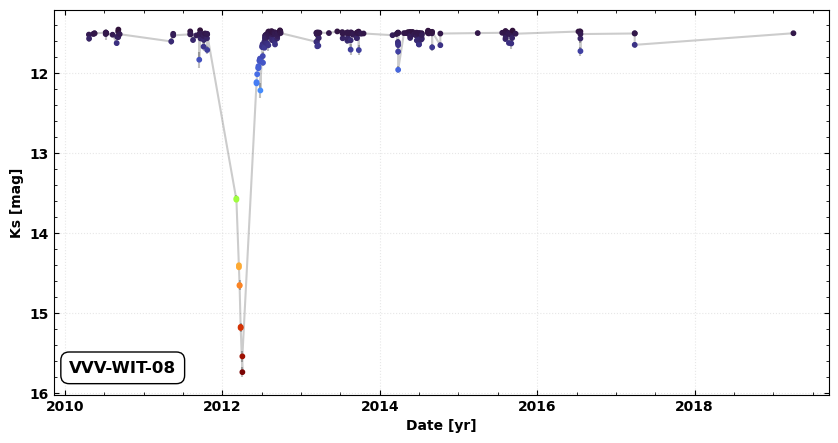

In [12]:
ks_mask = table_vvvx_source_lc['filter'] == 'Ks'

mjdobs = table_vvvx_source_lc['mjdobs'][ks_mask].data.data
dateobs = mjd_to_fractional_year(mjdobs)

mag = table_vvvx_source_lc['mag'][ks_mask].data.data
mag_err =  table_vvvx_source_lc['emag'][ks_mask].data.data


fig = plt.figure(figsize=(10, 5)) # Create a figure
ax = fig.add_subplot(1,1,1) 

# ax.errorbar(dateobs, mag, yerr=mag_err, fmt='o', label='Ks', ms=4, mfc='none', mec='C0', ecolor='C0', alpha=0.5)
ax.errorbar(dateobs, mag, yerr=mag_err, fmt='o', label='Ks', ms=0, ecolor='k', alpha=0.25)
ax.plot(dateobs, mag, alpha=0.2, color='k')
ax.scatter(dateobs, mag, c=mag, cmap='turbo', s=10, zorder=3)
ax.invert_yaxis()

ax.set_xlabel('Date [yr]')
ax.set_ylabel('Ks [mag]')

ax.text(0.02, 0.05, f'VVV-WIT-08', transform=ax.transAxes, fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
ax.grid(True, linestyle=':', alpha=0.3)

fig.savefig('./figures/VVV-WIT-08_lc.png', dpi=300, bbox_inches='tight')

## <a id='query_vvvx32'>3.2 Get light curves for multiple sources and plot </a>

Now we can plot for the top e.g. 25 in terms of Ks observtion epochs. 

In [13]:
num = 25

selected_columns = ['sourceid', 'ra', 'de', 'phot_ks_mean_mag', 'phot_z_mean_mag', 'phot_j_mean_mag', 'phot_ks_n_epochs'] # Define the columns to be selected
table_vvvx_sources = archive_catalogues.get_catalogues(tables=tablename_vvvx_sources, columns=selected_columns, top=num, order_by='phot_ks_n_epochs', order='descending') 

table_vvvx_source_lc_arr = ['']*num
for i in range(num):
    table_vvvx_source_lc_arr[i] = archive_catalogues.get_catalogues(tables=tablename_vvvx_sources_lc, conditions_dict={'sourceid': table_vvvx_sources['sourceid'][i]}, maxrec=3000)

[INFO]    :: The query to VVVX_VIRAC_V2_SOURCES returned 25 entries (with a limit set to maxrec=545346533)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2199 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2195 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2193 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2200 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2195 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2198 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2196 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2195 entries (with a limit set to maxrec=3000)
[INFO]    :: The query to VVVX_VIRAC_V2_LC returned 2198 entries (with a limit set to maxrec=3000)
[I

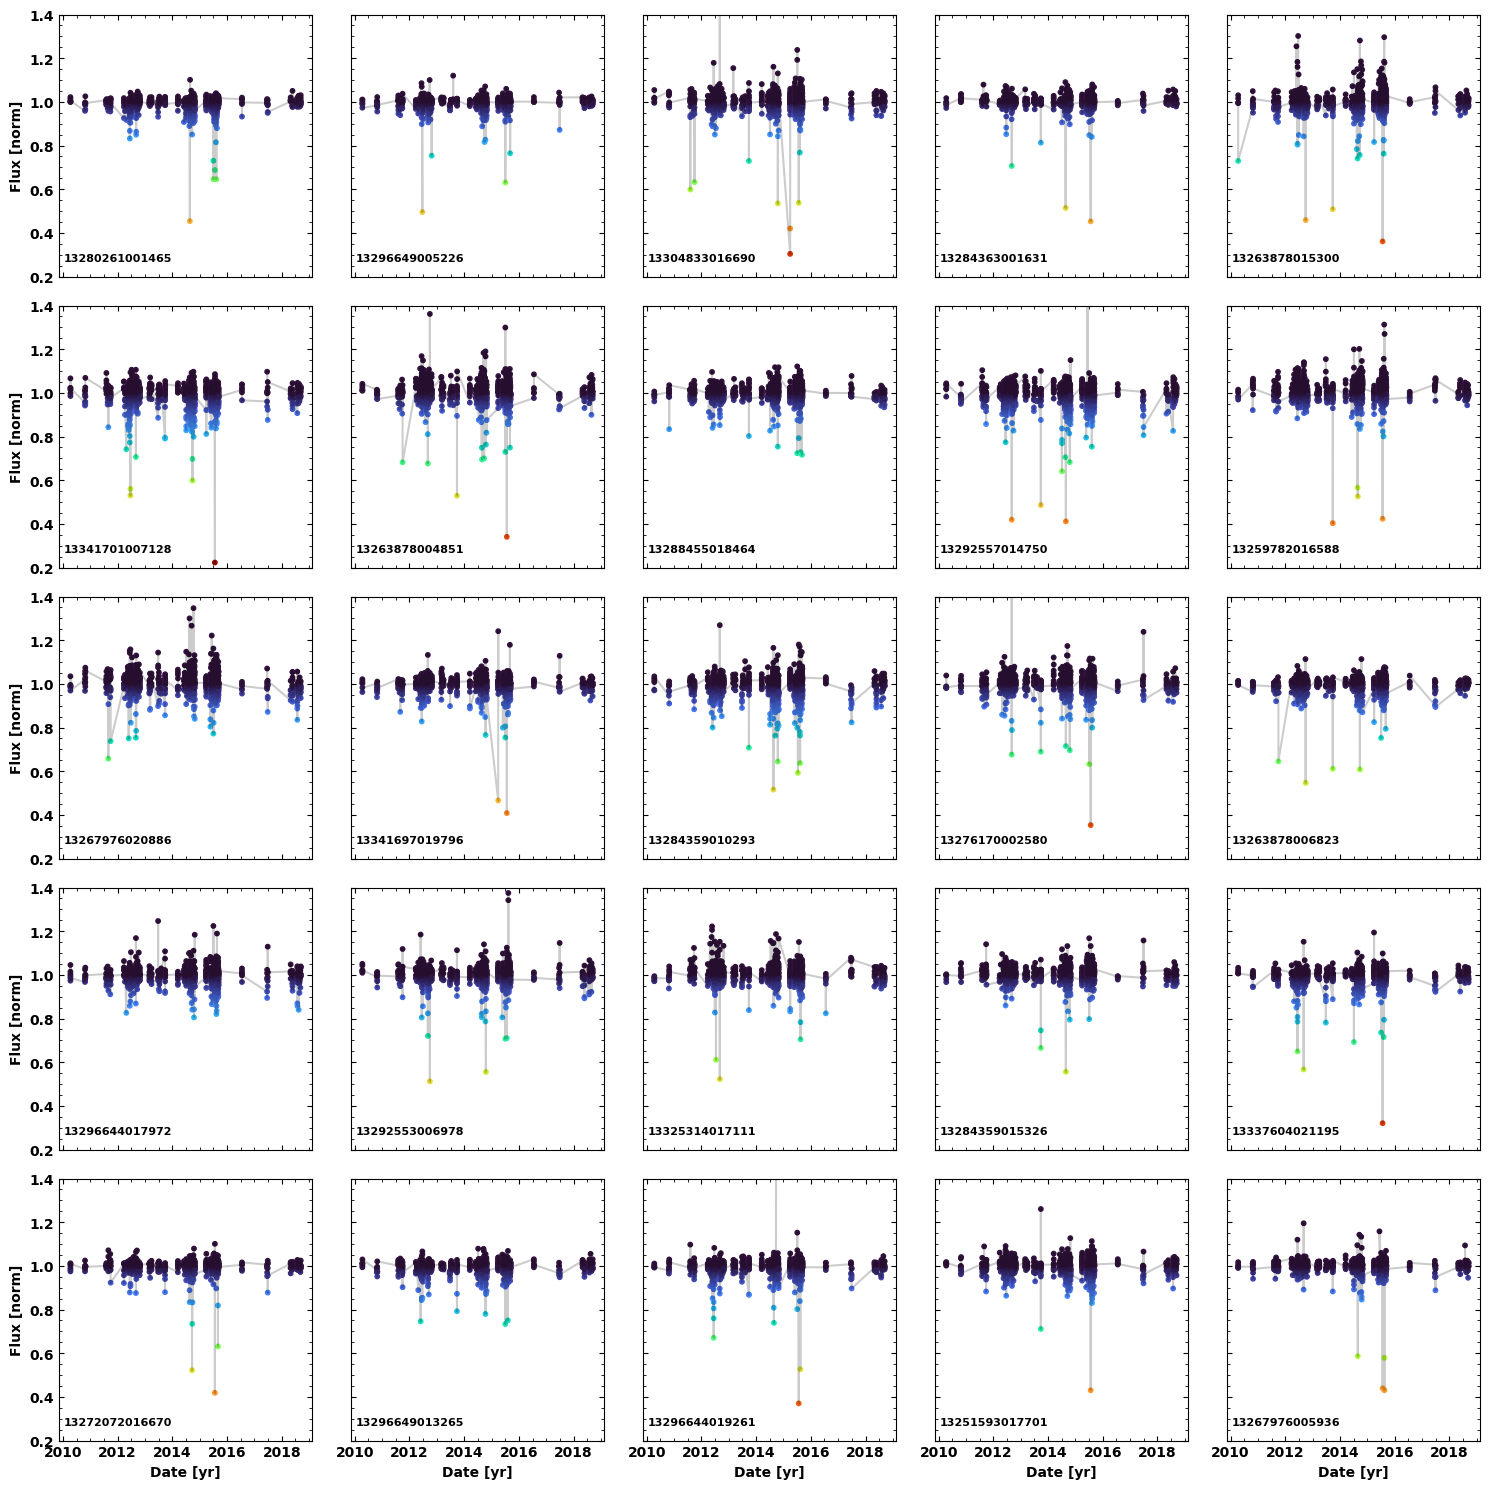

In [14]:
# Generalized labeling logic for a grid of subplots
def label_axes(ax, i, num_rows, num_cols):
    """
    Label the axes of a subplot based on its position in a grid.

    Parameters:
    ax (matplotlib.axes.Axes): The current subplot axis.
    i (int): The index of the current subplot (starting from 0).
    num_rows (int): Total number of rows in the grid.
    num_cols (int): Total number of columns in the grid.
    """
    # Calculate the row and column indices
    row = i // num_cols
    col = i % num_cols

    # Only set the y-axis label for the first column
    if col == 0:
        ax.set_ylabel('Flux [norm]')
    else:
        ax.set_yticklabels([])

    # Only set the x-axis label for the last row
    if row == num_rows - 1:
        ax.set_xlabel('Date [yr]')
    else:
        ax.set_xticklabels([])


fig = plt.figure(figsize=(15, 15)) # Create a figure
num_rows, num_cols = 5, 5  # Replace with your grid dimensions

for i in range(num):
    
    table_vvvx_source_lc = table_vvvx_source_lc_arr[i]

    ks_mask = table_vvvx_source_lc['filter'] == 'Ks'

    mjdobs = table_vvvx_source_lc['mjdobs'][ks_mask].data.data
    dateobs = mjd_to_fractional_year(mjdobs)

    mag = table_vvvx_source_lc['mag'][ks_mask].data.data
    mag_err =  table_vvvx_source_lc['emag'][ks_mask].data.data

    flux = 10**(-0.4*(mag))

    flux_norm = flux/np.nanmedian(flux)
    mag_norm = mag/np.nanmedian(mag)
    mag_err_norm = mag_err/np.nanmedian(mag)

    ax = fig.add_subplot(num_rows, num_cols, i+1) 

    ax.scatter(dateobs, flux_norm, c=flux_norm, cmap='turbo_r', s=10, norm=plt.Normalize(0.2, 1))
    ax.plot(dateobs, flux_norm, alpha=0.2, color='k')

    ax.text(0.02, 0.05, f'{table_vvvx_sources["sourceid"][i]}', transform=ax.transAxes, fontsize=8, ha='left', va='bottom')

    ax.set_ylim(0.2, 1.4)

    label_axes(ax, i, num_rows, num_cols)

fig.tight_layout()

fig.savefig('./figures/VVVX_sources_lc.png', dpi=300, bbox_inches='tight')

## Acknowledgements

Please cite the VIRAC2 paper (Smith et al. 2025, MNRAS [insert ref]) and add the following acknowledgement to articles which use data from this release:
“based on data products from VVV Survey (programme ID 179.B-2002) and VVVX Survey (pro-gramme ID 198.B-2004) observations made with the VISTA telescope at the ESO Paranal Obser-vatory”
VVV and VVVX data are published in the ESO Science Archive in the data collections identified by the following DOIs: https://doi.eso.org/10.18727/archive/67 and https://doi.eso.org/10.18727/archive/68.
 
According to the Data Access Policy for ESO data held in the ESO Science Archive Facility, all users are required to acknowledge the source of the data with appropriate citation in their publica-tions. 
 
Since processed data downloaded from the ESO Archive are assigned Digital Object Identifiers (DOIs), the following statement must be included in all publications making use of them: 
 * Based on data obtained from the ESO Science Archive Facility with DOI: https://doi.org/10.18727/archive/NNN1 
Publications making use of data which have been assigned an archive request number (of the form XXXXXX) must include the following statement in a footnote or in the acknowledgement: 
 * Based on data obtained from the ESO Science Archive Facility under request number XXXX. 
Science data products from the ESO archive may be distributed by third parties, and disseminat-ed via other services, according to the terms of the Creative Commons Attribution 4.0 Internation-al license. Credit to the ESO provenance of the data must be acknowledged, and the file headers preserved.
